# <font color="#004D7F"> 5 Selección de Variables</font> 

### Regresion Lineal utilizando Lasso

In [1]:
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

datos = sklearn.datasets.load_diabetes()
X = datos.data
Y = datos.target
nvars = X.shape[1]
n_alphas = 200
alphas = np.logspace(2, -2, n_alphas)
coefs = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X,Y)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
coefs= np.array(coefs)

for i in range(nvars):
    plt.plot(alphas, coefs[:,i], label= datos.feature_names[i])

ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coeficientes')
plt.title('Seleccion de variables segun parametro alpha de regularización Lasso')

plt.legend(loc='upper right')
ax.legend(loc='upper right', ncol=2, fancybox=True)

¿Que valor darías a $\alpha$ para quedarte con las 5 variables más influyentes?

# <font color="#004D7F"> 5 Selección de Variables - Métricas filter</font> 

### Métricas univariadas para problemas de clasificación

> Test paramétrico ANOVA, tiene como hipótesis nula el que, para cada posible valor de la clase, la media de una variable no varía. Solo captura relaciones lineales

> MI, Mutual Information, captura cualquier tipo de relación

Cuanto mayor es el valor de la métrica, más relacion del atributo con la clase. Un valor 0 significa independencia total entre variables.

## <font color="#004D7F"> Ranking por test ANOVA</font> 
### Seleccionar las K mejores variables con SelectKBest 

Ranking: [27 22  7 20  2  0 23  3  6 26]


Text(0.5, 0, 'Indice de la variable')

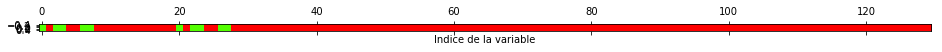

In [2]:
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

datos = sklearn.datasets.load_breast_cancer()
X = datos.data
Y = datos.target
# Añadimos 100 variables con ruido despues de las 30 originales 
# No deberian ser seleccionadas
semilla = 0
random = np.random.RandomState(semilla)
ruido = random.normal(size=(len(X), 100))
X_ruido = np.hstack([X, ruido])
X_t, X_T, Y_t, Y_T = train_test_split(X_ruido,Y,test_size=0.2, random_state=semilla)

# Seleccionar las 10 mejores segun test ANOVA
K = 10
ranking = SelectKBest(score_func = f_classif, k=K)
ranking.fit(X_t,Y_t)
X_t_proyec = ranking.transform(X_t)

# Ver ranking visual y de variables seleccionadas 
print("Ranking: {}".format(np.argsort(ranking.scores_)[::-1][:K]))
seleccionados = ranking.get_support()
plt.matshow(seleccionados.reshape(1,-1), cmap='prism')
plt.xlabel("Indice de la variable")


# <font color="#004D7F"> 5 Selección de Variables</font> 
## <font color="#004D7F"> Ranking por test ANOVA</font> 

### Porcentaje de variables seleccionadas SelectPercentile

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value 

<ErrorbarContainer object of 3 artists>

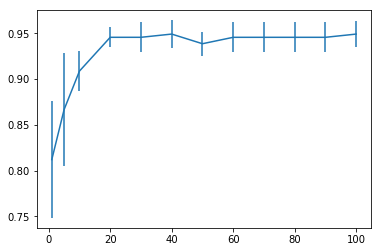

In [3]:
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

seleccion = SelectPercentile(f_classif)
pipe = Pipeline([('seleccion', seleccion), ('lr', LogisticRegression())])

score_means = list()
score_stds = list()
porcentajes = [1,5] + list(np.linspace(10,100,10))

for p in porcentajes:
    pipe.set_params(seleccion__percentile=p)
    this_scores = cross_val_score(pipe, X, Y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
    
plt.errorbar(porcentajes, score_means, np.array(score_stds))

# <font color="#004D7F"> 5 Selección de Variables</font> 
## <font color="#004D7F"> Ranking por test ANOVA</font> 

### Evaluar algoritmo utilizando 2 métodos de selección ANOVA vs MI

M.I. -> Mutual Information

In [4]:
from sklearn.feature_selection import mutual_info_classif
# Seleccionar las 10 mejores segun test ANOVA
K = 10
ranking_F = SelectKBest(score_func = f_classif, k=K)
ranking_F.fit(X_t,Y_t)
X_seleccionF = ranking_F.transform(X_t)

# Seleccionar las 10 mejores por MI
K = 10
ranking_MI = SelectKBest(score_func = mutual_info_classif, k=K)
ranking_MI.fit(X_t,Y_t)
X_seleccionMI = ranking_MI.transform(X_t) # proyectar

# crear modelos
lr = LogisticRegression(); lr_F = LogisticRegression(); lr_MI = LogisticRegression();
lr.fit(X_t,Y_t); lr_F.fit(X_seleccionF,Y_t); lr_MI.fit(X_seleccionMI, Y_t)

# Proyectar test y validar modelos
XT_F =  ranking_F.transform(X_T); XT_MI = ranking_MI.transform(X_T)
score = lr.score(X_T, Y_T)
scoreF = lr_F.score(XT_F, Y_T)
scoreMI = lr_MI.score(XT_MI, Y_T)

print('Acc sin seleccion: {:.4f}'.format(score))
print('Acc con 10 mejores ANOVA: {:.4f}'.format(scoreF))
print('Acc con 10 mejores MI: {:.4f}'.format(scoreMI))

Acc sin seleccion: 0.9298
Acc con 10 mejores ANOVA: 0.9386
Acc con 10 mejores MI: 0.9474


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
